# Intrinsic Dimensionality
EMIT_L2A_RFL_001_20240427T165527_2411811_009

In [17]:
import hyperquest

from spectral import *
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries
from sklearn.decomposition import PCA
import numpy as np

In [18]:
# Define path to EMIT surface reflectance
path_to_data = '../tests/data/EMIT_L2A_RFL_001_20240427T165527_2411811_009.nc'

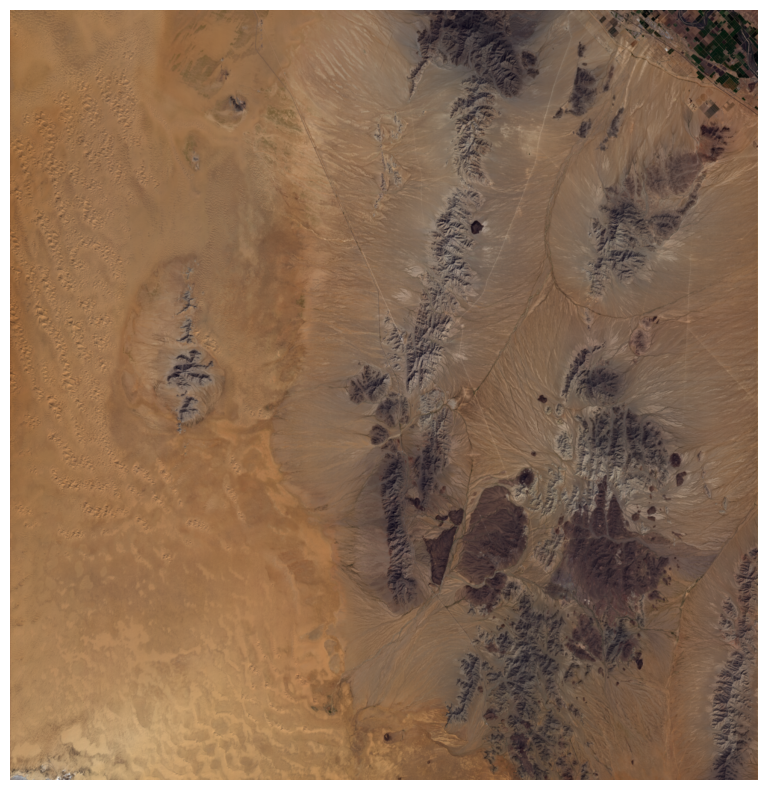

In [19]:
# Load raster
array, fwhm, wave, obs_time = hyperquest.retrieve_data_from_nc(path_to_data)
red = array[:,:,38]
blue = array[:,:,11]
green = array[:,:,24]

red= np.ma.masked_equal(red, -9999)
green = np.ma.masked_equal(green, -9999)
blue = np.ma.masked_equal(blue, -9999)

# Normalize the values for display
plt.figure(figsize=(10, 10))
red_normalized = (red - red.min()) / (red.max() - red.min())
green_normalized = (green - green.min()) / (green.max() - green.min())
blue_normalized = (blue - blue.min()) / (blue.max() - blue.min())
rgb_image = np.dstack((red_normalized, green_normalized, blue_normalized))
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.670093546788448..3.4804532856165293].


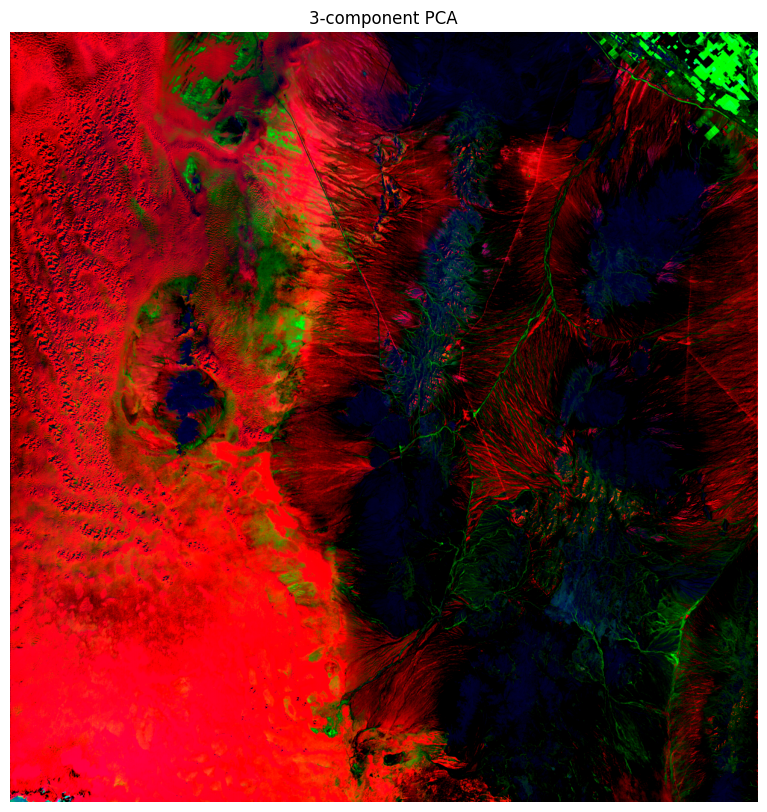

In [26]:
# first 3 components
pca = PCA(n_components=3)
rows, cols, bands = array.shape
array[np.isnan(array)] = -9999
array_reshaped = array.reshape(-1, bands)
array_pca = pca.fit_transform(array_reshaped).reshape(rows, cols, -1)

# SLIC
n_segments = 100000
compactness = 0.5


segments = slic(array_pca, 
                n_segments=n_segments, 
                compactness=compactness)


plt.figure(figsize=(10, 10))
plt.imshow(array_pca)
plt.title("3-component PCA")
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.670093546788448..3.4804532856165293].


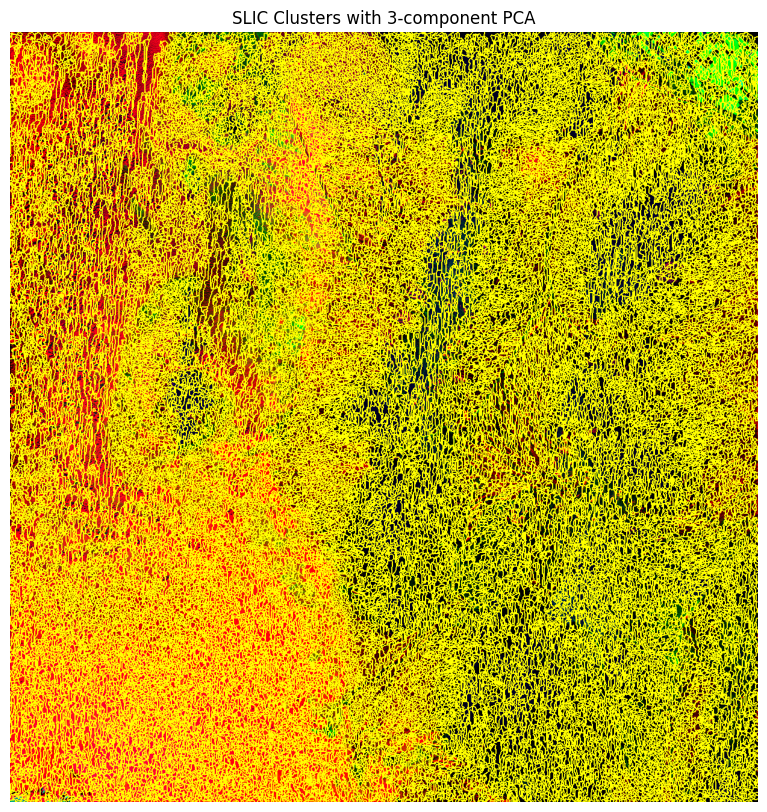

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(mark_boundaries(array_pca, segments))
plt.title("SLIC Clusters with 3-component PCA")
plt.axis("off")
plt.show()

In [28]:
snr, noise_variance = hyperquest.hrdsdc(path_to_data, n_segments, compactness, 
                                        n_pca=3, ncpus=8,
                                        no_data_value=-9999)

/opt/homebrew/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


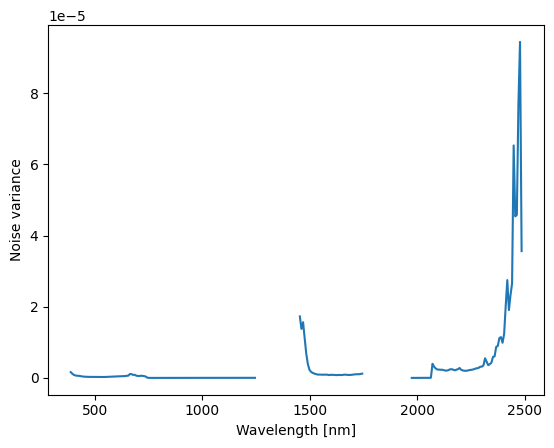

In [29]:
import matplotlib.pyplot as plt
plt.plot(wave, noise_variance)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Noise variance')
plt.show()

In [30]:
k_eff = hyperquest.random_matrix_theory(path_to_data = path_to_data,
                                        noise_variance = noise_variance,
                                        alpha = 0.5,
                                        no_data_value = -9999)

/opt/homebrew/lib/python3.11/site-packages/hyperquest/intrinsic_dimensionality.py:110: RuntimeWarning: invalid value encountered in scalar divide
  X.append((evec_Pi[:,i].T @ N @ evec_S[:,i]) / (evec_Pi[:,i].T @ evec_S[:,i]))


In [31]:
k_eff

26

### K-eff=26 is probably too large given this image (?).
TODO: assess method of Asad Mahmood et al., https://ieeexplore.ieee.org/abstract/document/8077550 for correlated noise..

Tough to say really with out digging in deeper. But as noted in the literature it is sensitive to method used for noise. changing the number of SLIC clusters greatly changes my k_eff. 